<a href="https://colab.research.google.com/github/patrick-hanley/thought_experiments/blob/master/_notebooks/2021_02_23_numerical_transformations_entire_wine_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "Numerically transform the entire wine dataset"
> "Preprocess the entire wine dataset and compare results to baaseline."


- toc: false
- branch: master
- badges: false
- comments: true
- image: images/wine_dataset/Screen Shot 2021-02-24 at 3.21.12 PM.png
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

#![]({{ site.url }}{{ site.baseurl }}/images/wine_dataset/iStock-615737086-768x512.jpg)

Load libraries

In [ ]:

# !pip uninstall torch torchvision -y
# !pip install torch==1.4.0 torchvision==0.5.0

In [8]:
#@title
#collapse_output
# Standard Library Imports

%reload_ext autoreload
%autoreload 2
%matplotlib inline

!pip install fastai --upgrade --q
from pathlib import Path
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
import matplotlib.pyplot as plt

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
import numpy as np
from scipy.stats import kurtosis, skew
from scipy import stats
import math
import warnings
warnings.filterwarnings("error")

from google.colab import drive
mnt=drive.mount('/content/gdrive', force_remount=True)



Exception ignored in: <_io.FileIO name=66 mode='wb' closefd=True>
Exception ignored in: <_io.FileIO name=67 mode='rb' closefd=True>


Mounted at /content/gdrive


# I will explore the transformations using the [wine data set](https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009) from Kaggle.

Load dataset

In [9]:
#hide
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'redwine'
csv_path = (base_dir+'/winequality-red.csv')
df=pd.read_csv(csv_path)

# The following numerical transformations will be evaluated on the dataset:


*   Log 
*   Square Root
*   Box-Cox
*   Yeo-Yohnson
*   Quantile
*   Clipping



In [10]:
#collapse

# https://www.marsja.se/transform-skewed-data-using-square-root-log-box-cox-methods-in-python/
def box_cox_transform(bc, X_train, X_test):
  
  try:
    X_trans_bc = bc.fit(X_train).transform(X_test)
  except:
    # datax = max(X_train+1) - X_train
    # datay = max(X_train+1) - X_train
    datax, datay = reverse_distribution(X_train, X_test)
    X_trans_bc = bc.fit(datax).transform(datay)
  return X_trans_bc

def log_transform(x):
  try:
    X_trans = np.log(x)
  except:
    datax, datay = reverse_distribution(x, x)
    X_trans = np.log(datax)
  return X_trans

def sqr_transform(x):
  return np.square(x)

def cubic_transform(x):
  #three = np.full(len(x), 3)
  return np.power(x, 3)

def sqrt_transform(x):
  return np.sqrt(x)

def reverse_distribution(X_train, X_test):
  # data can not have negative values
  datax = max(X_train+1) - X_train
  datay = max(X_test+1) - X_test
  return (datax, datay)

def get_stats(trns_name, data):
  s = skew(data)
  s_str = '%.2f'%(s)
  #vk = '%.2f'%(kurtosis(data))
  k2, p = stats.normaltest(data)
  ks = '%.2f'%(k2)
  # pvalue = '%.2f'%(p)
  title = "\n".join([trns_name, s_str, ks])
  return (s, k2, title)

def plot_transforms(df, feat, log=False):
  #rng = np.random.RandomState(304)
  N_SAMPLES = 1000
  FONT_SIZE = 12
  BINS = 100
  # initialize models
  bc = PowerTransformer(method='box-cox')
  yj = PowerTransformer(method='yeo-johnson')
  # n_quantiles is set to the training set size rather than the default value
  # to avoid a warning being raised by this example
  qt = QuantileTransformer(n_quantiles=500, output_distribution='normal',
                          random_state=0)
  X=df.iloc[:,feat]
  print (df.columns[feat], X.nunique())
  

  if len(X.unique())> 10:
    X = X.values.reshape(-1, 1)


    # perform power transforms and quantile transform
    X_trans_bc = box_cox_transform(bc, X, X) # bc.fit(X_train).transform(X_test)

    X_trans_yj = yj.fit(X).transform(X)

    X_trans_qt = qt.fit(X).transform(X)

    X_trans_sqrt = sqrt_transform(X)

    X_trans_log = log_transform(X)

    #X_trans_sqr = sqr_transform(X)

    #X_trans_cube = cubic_transform(X)

    transforms = [X, X_trans_bc, X_trans_yj, X_trans_qt, X_trans_sqrt,
                  X_trans_log]#, X_trans_sqr, X_trans_cube]

    titles = ['train', 'trans_bc', 'trans_yj', 'trans_qt', 
              'trans_sqrt', 'trans_log']#, 'trans_sqr', 'trans_cube']

  else:
    X = X.values.reshape(-1, 1)
    transforms = [X]
    titles = ['X_train']


  #Set up fix and axes for plotting
  fig, axes = plt.subplots(nrows=1, ncols=len(titles), figsize=plt.figaspect(.2), 
                           sharey=True)

  # trackers for skew and kurtosis
  s_best = 9999.
  k_best= 9999.
  title_best=[]
  best_model=''
  for t, ax, trns_name in zip(transforms, axes, titles):
    
    # histogram each model
    ax.hist(t, bins=BINS, log=log, range=(np.nanmin(t), np.nanmax(t)))
    
    # analyze distribution
    s, k2, title = get_stats(trns_name, t)

    # find best skew, then best kurtosis
    if abs(s) < s_best:
      title_best = title
      t_best = t
      s_best = abs(s)
      best_model = trns_name
      best_ax = ax
      k_best = abs(k2)
    elif abs(s)==s_best:
      if abs(k2) < k_best:
        title_best = title
        k_best = abs(k2)
        t_best=t
        best_model = trns_name
        best_ax = ax
    
    title = "\n".join([df.columns[feat], title])
    ax.set_title(title, fontsize=FONT_SIZE)

  col = '_'.join([df.columns[feat], best_model]) 
  
  transfored_df = pd.DataFrame(t_best, columns=[col])

  print ("Best:{}".format(best_model))
  best_ax.set_facecolor('pink')
  plt.show()

  # return transformed array from the best model
  return (transfored_df)

def remove_outliers(X):
  mean = np.mean(X)
  standard_deviation = np.std(X)
  distance_from_mean = abs(X - mean)
  max_deviations = 1.5
  not_outlier = distance_from_mean < max_deviations * standard_deviation
  no_outliers = X[not_outlier]
  return no_outliers



def clip_feature(df, max_deviations=2, type='std'):
  """provide dataFrame and get a clipped daataframe back including 2 additional
  columns indicating the index of clippage.
  """

  clipped_dfs = []
  for feature in df.columns:

    mean = df[feature].mean()
    standard_deviation = df[feature].std()

    upper = mean + (max_deviations * standard_deviation)
    lower = mean - (max_deviations * standard_deviation)
    val = df[feature].values

    if type == 'std':
      lower_value = lower
      upper_value = upper
      V = np.clip(val, lower_value, upper_value, out=None)
    elif type == 'mean':
      lower_value = mean
      upper_value = mean
      V = np.where((val<lower)|(val>upper), mean, val)
      
    elif type == 'median':
      median = df[feature].median()
      lower_value = median
      upper_value = median
      V = np.where((val<lower)|(val>upper), median, val)

    #V = np.clip(val, lower_value, upper_value, out=None)
    clip_low = np.where(val<lower, True, False)
    clip_high = np.where(val>upper, True, False)

    #confirm the series was clipped
    len_low = len(np.unique(clip_low, return_counts=True)[1])
    len_high = len(np.unique(clip_high, return_counts=True)[1])

    if (len_low)>1 or (len_high)>1:
      clipped_name = '_'.join(['clip', type, str(max_deviations), feature])
      is_clipped_low = '_'.join(['IS_CLIP_LOW', type, str(max_deviations), feature])
      is_clipped_high = '_'.join(['IS_CLIP_HIGH', type, str(max_deviations), feature])
      dv=pd.DataFrame({clipped_name:V, is_clipped_low:clip_low, is_clipped_high:clip_high} )
    
      clipped_dfs.append(dv)
  clipped_dfs = pd.concat(clipped_dfs, axis=1)
  return clipped_dfs



# I came across this funtion on Kaggle(I think) and found it incredibly helpful
# https://gist.github.com/harperfu6/5ea565ee23aaf8461a840c480490cd9a
from scipy import stats
pd.set_option("display.max_rows", 1000)
def resumetable(df):
    print(f'Dataset Shape: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name', 'dtypes']]
    summary['Missing'] = df.isnull().sum().values
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values
    
    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = \
        round(stats.entropy(df[name].value_counts(normalize=True), base=2), 2)
    
    return summary

def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

# Lets take a quick look at our data.

*   11 features and 1 target
*   1600 rows of data

For a more in depth analysis see the previous blog XXXX.



In [11]:
#collapse
resumetable(df)

Dataset Shape: (1599, 12)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,fixed acidity,float64,0,96,7.4000,7.8000,7.800,5.94
1,volatile acidity,float64,0,143,0.7000,0.8800,0.760,6.39
2,citric acid,float64,0,80,0.0000,0.0000,0.040,5.87
3,residual sugar,float64,0,91,1.9000,2.6000,2.300,4.78
4,chlorides,float64,0,153,0.0760,0.0980,0.092,6.22
5,free sulfur dioxide,float64,0,60,11.0000,25.0000,15.000,5.08
6,total sulfur dioxide,float64,0,144,34.0000,67.0000,54.000,6.60
7,density,float64,0,436,0.9978,0.9968,0.997,7.96
8,pH,float64,0,89,3.5100,3.2000,3.260,5.91
9,sulphates,float64,0,96,0.5600,0.6800,0.650,5.73


I wanted a simple way to visualize the distributions of the feaatures and also quickly see how they could be transormed into a guasian distribution needed for neural networks.  I created a library that runs the Transforms listed above on each feature and automatically selects the optimal transform based on the skew and kurtosis.

Let's see an example.  The plots below are evaluating all 11 features.

fixed acidity 96
Best:trans_bc


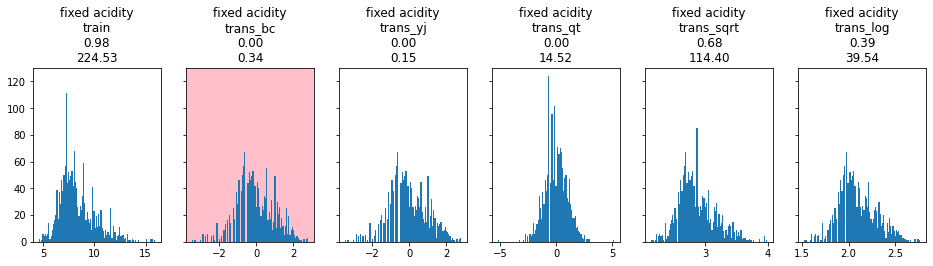

volatile acidity 143
Best:trans_bc


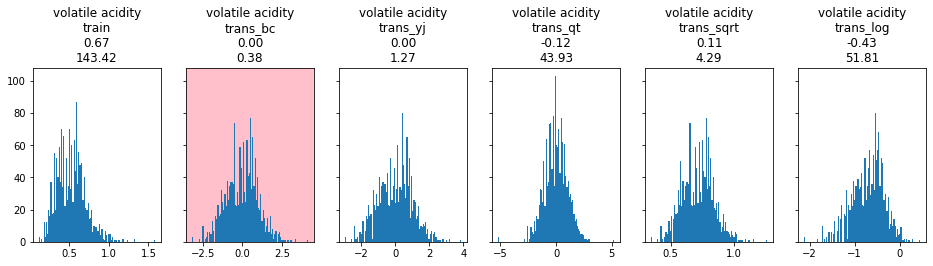

citric acid 80
Best:trans_yj


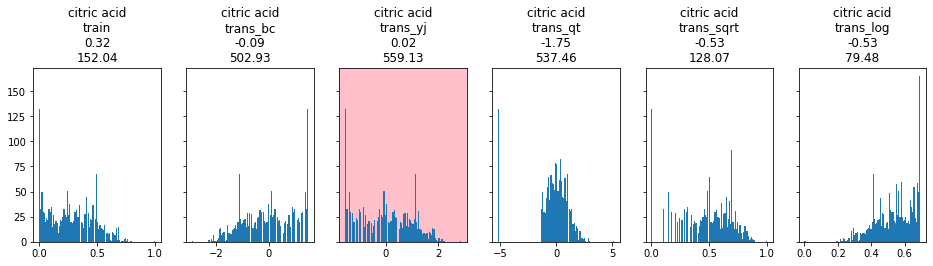

residual sugar 91
Best:trans_yj


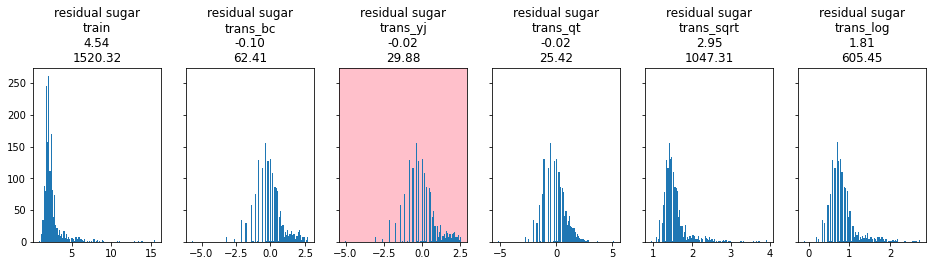

chlorides 153
Best:trans_qt


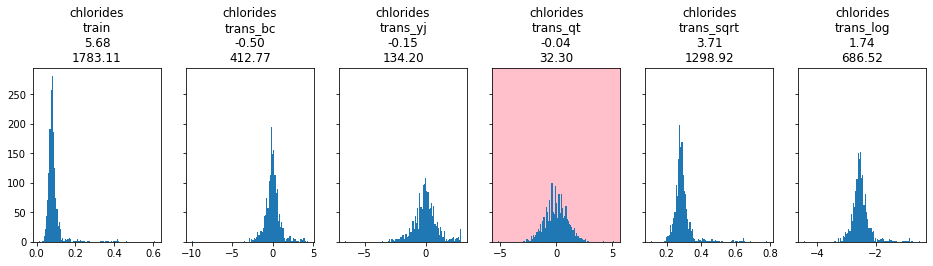

free sulfur dioxide 60
Best:trans_yj


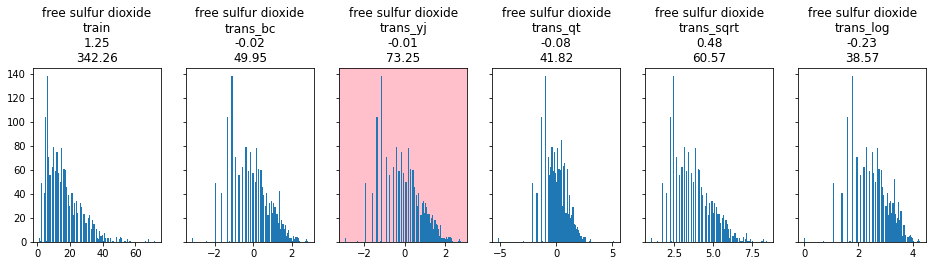

total sulfur dioxide 144
Best:trans_yj


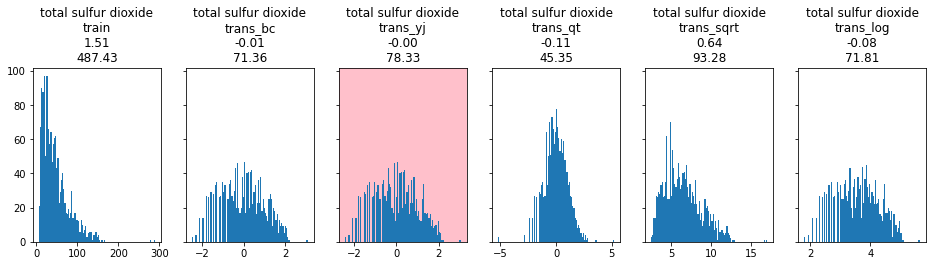

density 436
Best:trans_qt


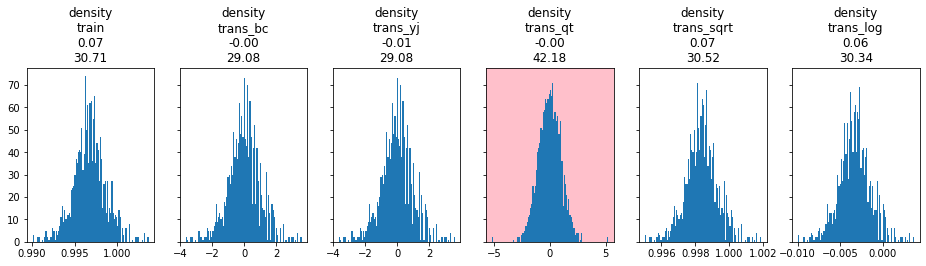

pH 89
Best:trans_bc


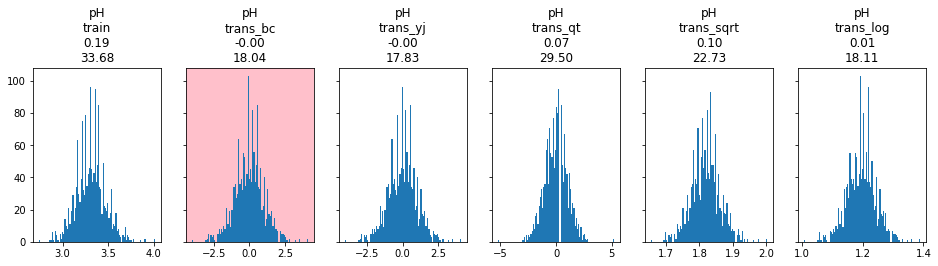

sulphates 96
Best:trans_qt


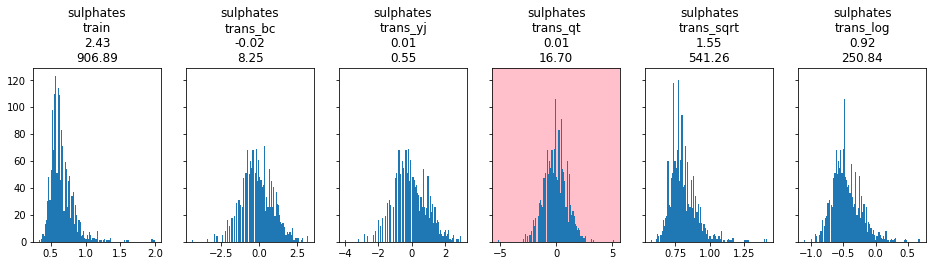

alcohol 65
Best:trans_qt


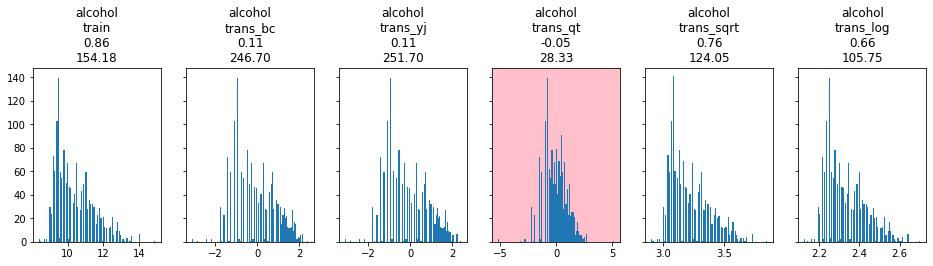

In [12]:
#collapse_output
#get column locations of all features (dep_var = int64)
int_features_indices = np.where(df.dtypes == 'float64')[0]

transform_dfs = []
for feature_index in int_features_indices:
  transform_df = plot_transforms(df, feature_index, log=False)
  transform_dfs.append(transform_df)

transform_dfs = pd.concat(transform_dfs, axis=1)

#save to csv for later processing
csv_path = (base_dir+'/transform_dfs.csv')
transform_dfs.to_csv(csv_path, index=False)

Let's check the shape.  It's the same as the default (with dep_variable removed)

In [13]:
transform_dfs.shape # 11 features

(1599, 11)

# Clip the data

Lets now clip the data to a limit of 2 standard deviations and then run it through the transforms.

The Clip transformation does a few things.


1.   Clips values to be within X number of standard deviations.
2.   The values outside the range, will be adjusted to 1 of the 3 options:
>*  X standard deviations
>*  mean
>*  median
3.   Additional columns will be added to indicate if a value was clipped low or high.




Let's see a sample output.


In [ ]:
train_df = df.copy()
train_df.drop('quality', axis=1, inplace=True)

clipped_3_median_df = clip_feature(train_df, 3, 'median')
clipped_2p5_median_df = clip_feature(train_df, 2.5, 'median')
clipped_2_median_df = clip_feature(train_df, 2, 'median')
clipped_1p5_median_df = clip_feature(train_df, 1.5, 'median')
clipped_1_median_df = clip_feature(train_df, 1, 'median')

clipped_median_dfs = pd.concat([clipped_3_median_df,
                                         clipped_2p5_median_df,
                                         clipped_2_median_df,
                                         clipped_1p5_median_df,
                                         clipped_1_median_df], axis=1)

#save to csv for later processing
csv_path = (base_dir+'/clipped_median_dfs.csv')
clipped_median_dfs.to_csv(csv_path, index=False)

There are 3 columns per feature for each clip.  I selected 5 different standard deviations, so there are a total of 11 x 3 x 5 = 165 columns

In [ ]:
clipped_median_dfs.shape # 165 new columns

(1599, 165)

We get a new dataframe that consists of the clipped values and a IS_CLIP_LOW and IS_CLIP_HIGH column.


Now, lets run our clipped features through the Transforms.  I will show that my model considers these clipped transforms as some of the most important features.

clip_median_3_fixed acidity 88
Best:trans_bc


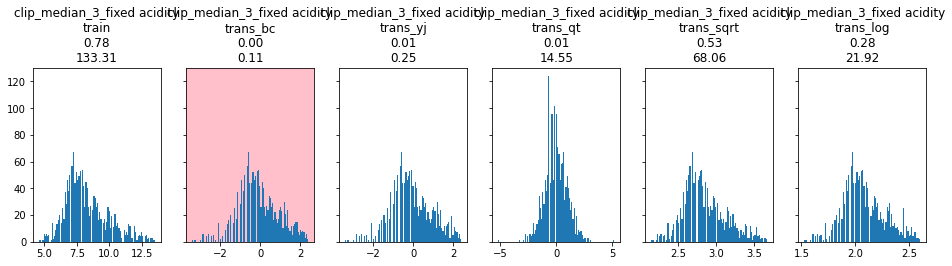

clip_median_3_volatile acidity 134
Best:trans_yj


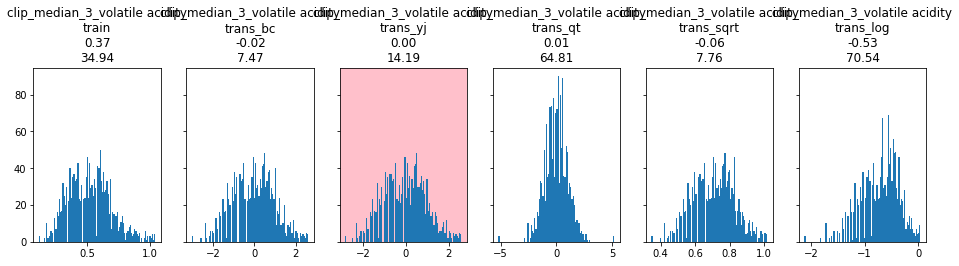

clip_median_3_citric acid 79
Best:trans_yj


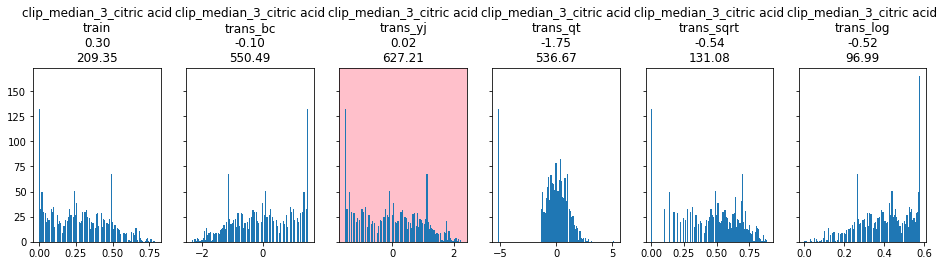

clip_median_3_residual sugar 71
Best:trans_qt


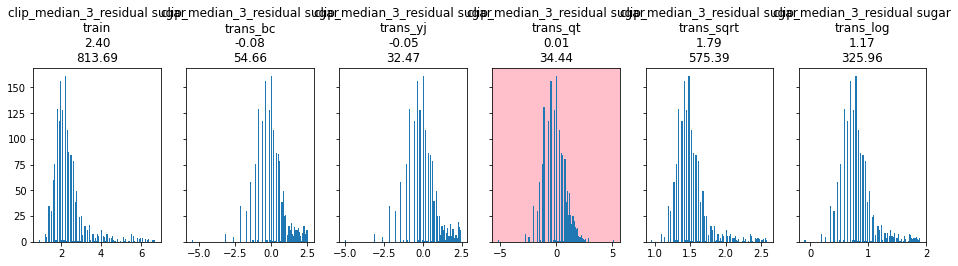

clip_median_3_chlorides 125
Best:trans_bc


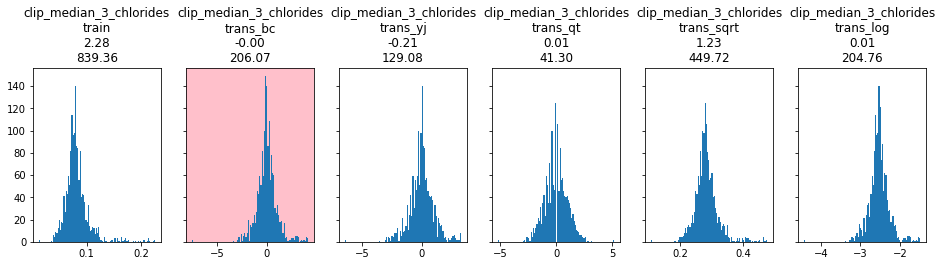

clip_median_3_free sulfur dioxide 49
Best:trans_yj


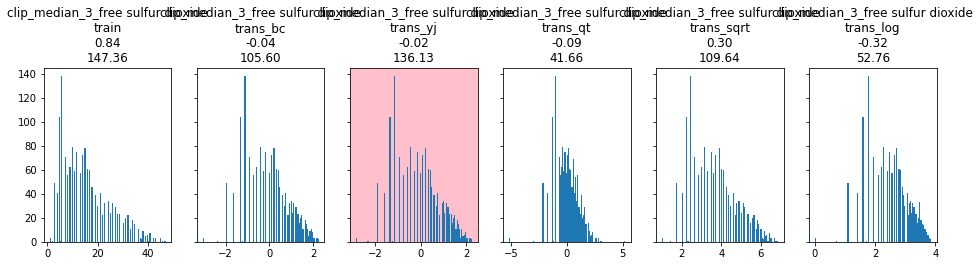

clip_median_3_total sulfur dioxide 133
Best:trans_qt


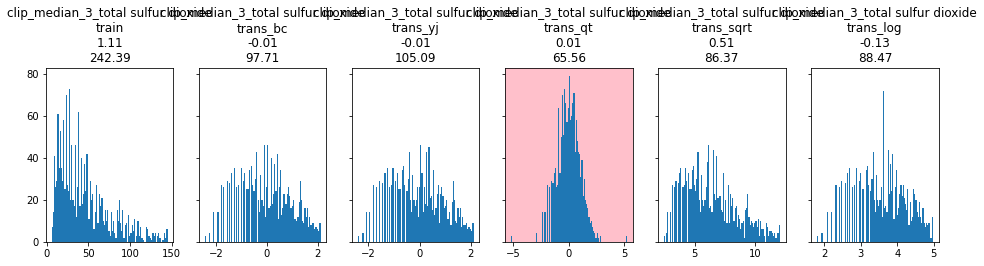

clip_median_3_density 425
Best:trans_yj


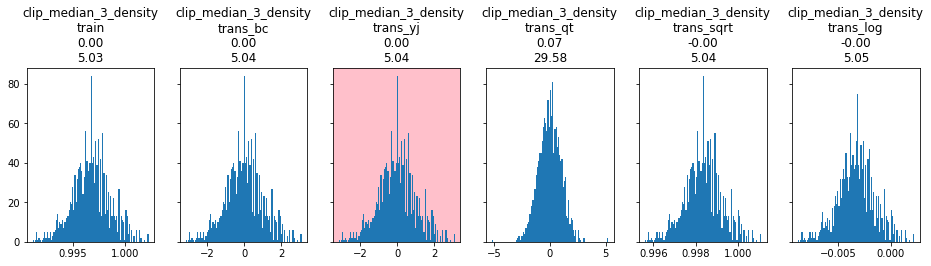

clip_median_3_pH 84
Best:trans_yj


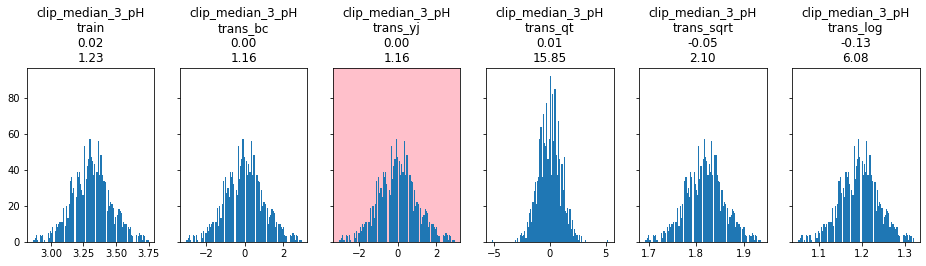

clip_median_3_sulphates 79
Best:trans_bc


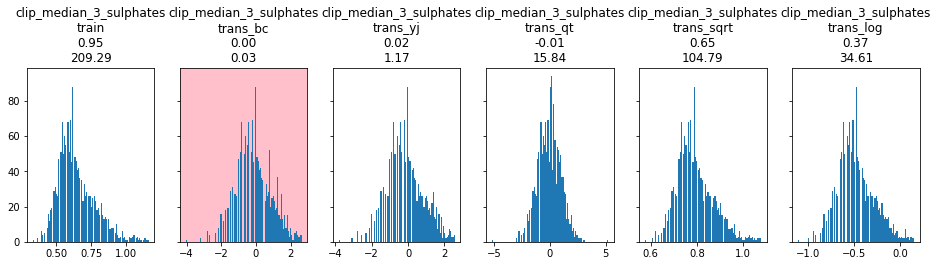

clip_median_3_alcohol 63
Best:trans_bc


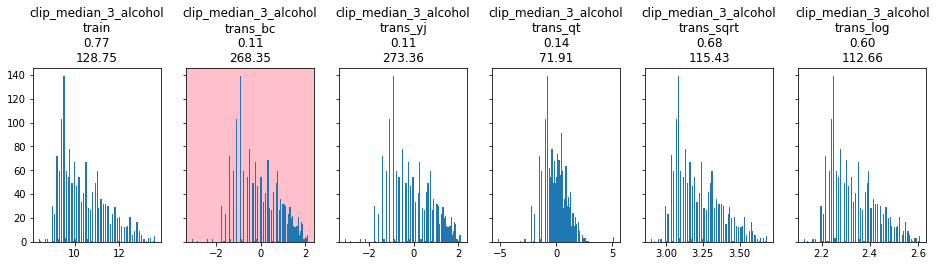

clip_median_2.5_fixed acidity 80
Best:trans_bc


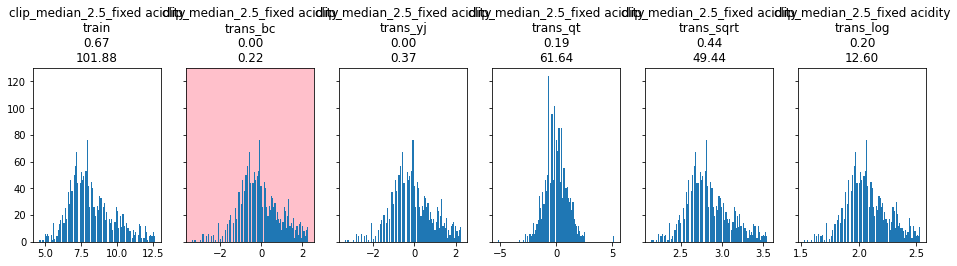

clip_median_2.5_volatile acidity 126
Best:trans_yj


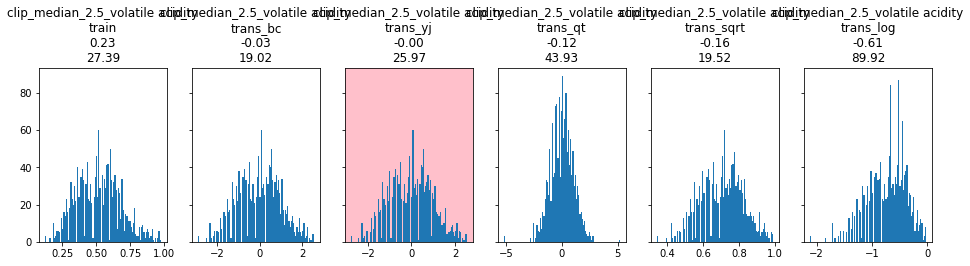

clip_median_2.5_citric acid 76
Best:trans_yj


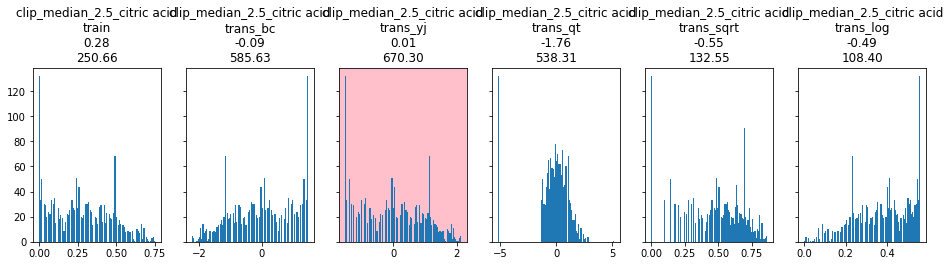

clip_median_2.5_residual sugar 64
Best:trans_yj


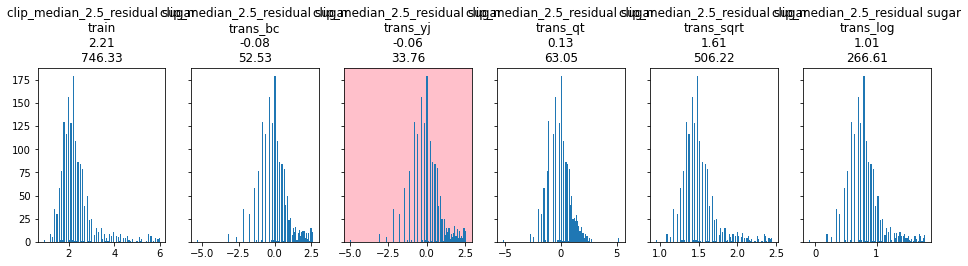

clip_median_2.5_chlorides 120
Best:trans_qt


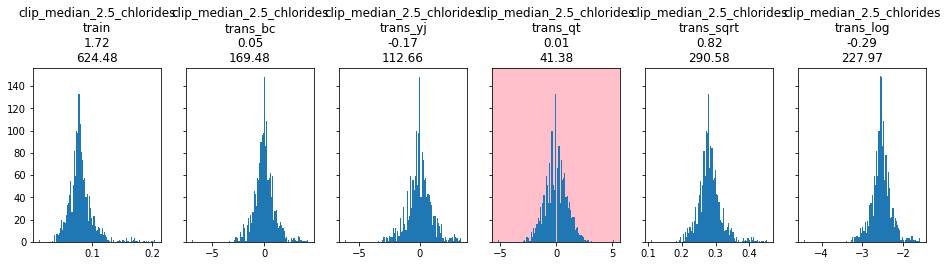

clip_median_2.5_free sulfur dioxide 45
Best:trans_yj


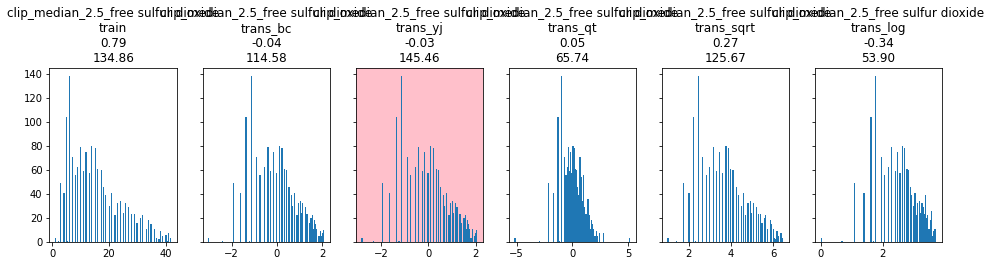

clip_median_2.5_total sulfur dioxide 119
Best:trans_yj


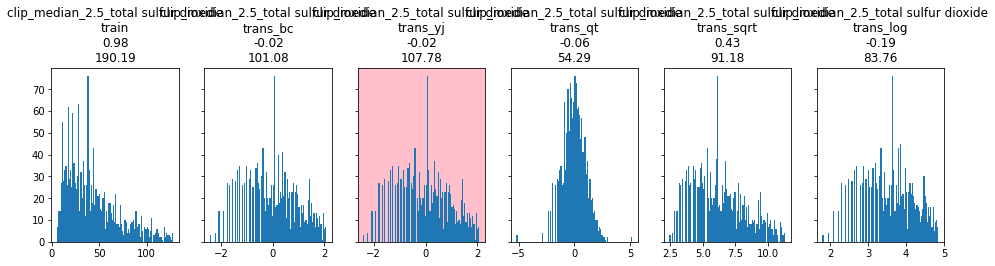

clip_median_2.5_density 412
Best:trans_bc


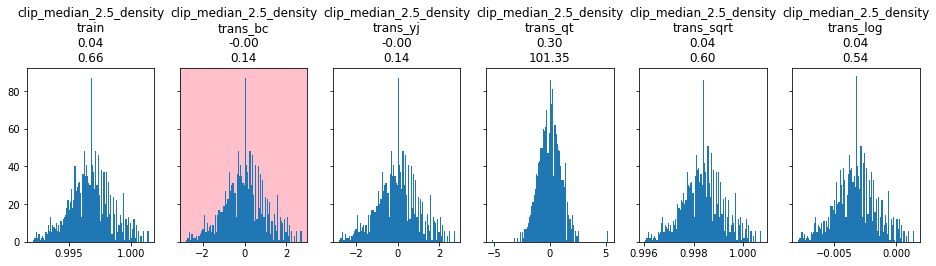

clip_median_2.5_pH 73
Best:trans_yj


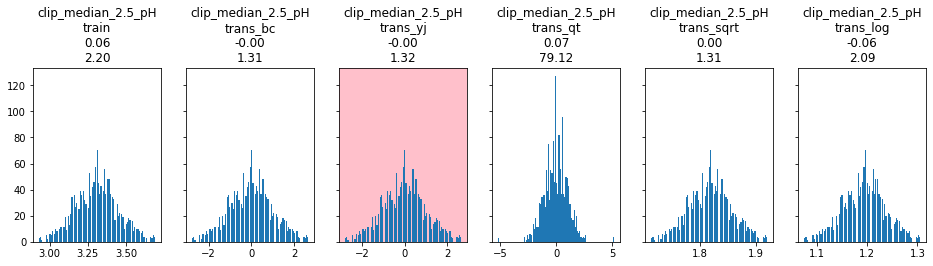

clip_median_2.5_sulphates 71
Best:trans_bc


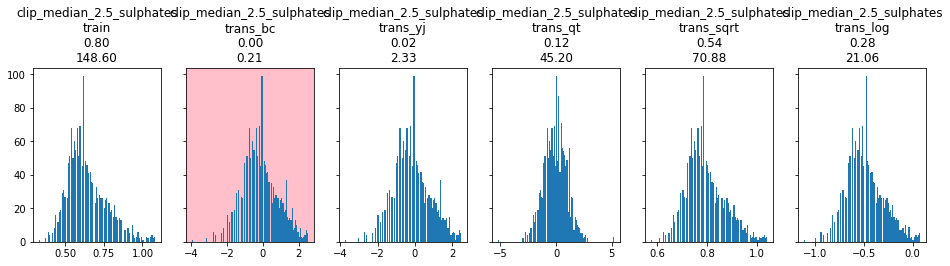

clip_median_2.5_alcohol 56
Best:trans_bc


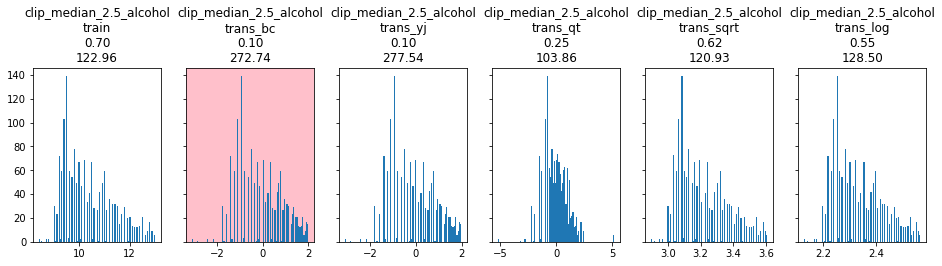

clip_median_2_fixed acidity 70
Best:trans_bc


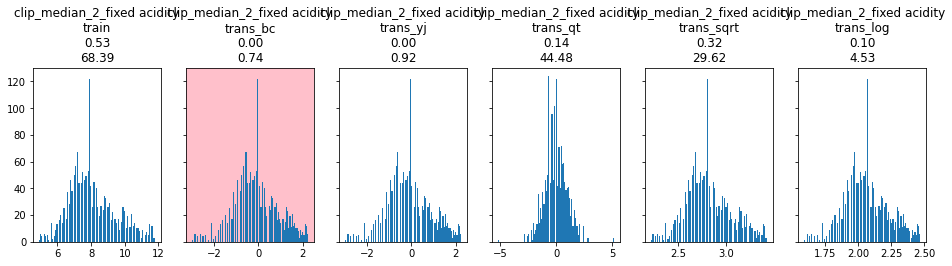

clip_median_2_volatile acidity 112
Best:trans_yj


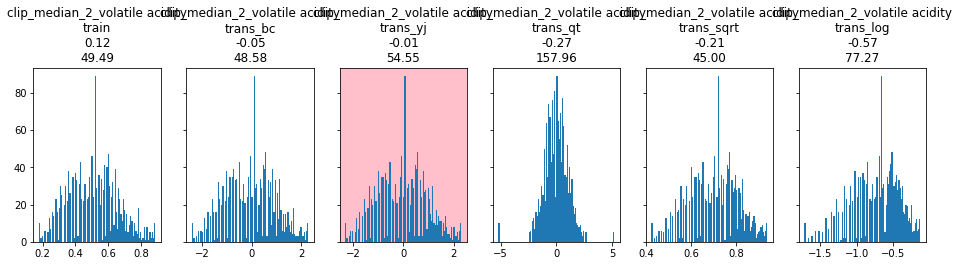

clip_median_2_citric acid 67
Best:trans_yj


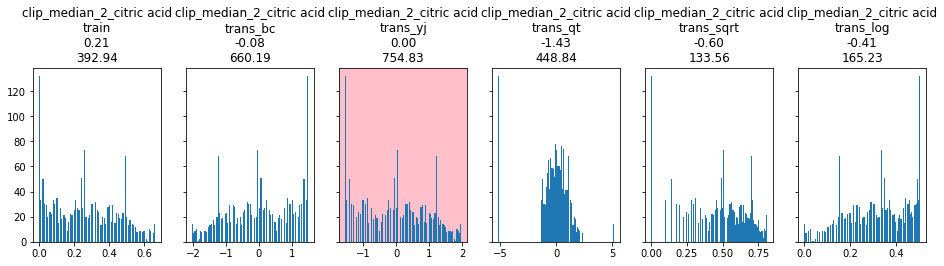

clip_median_2_residual sugar 57
Best:trans_yj


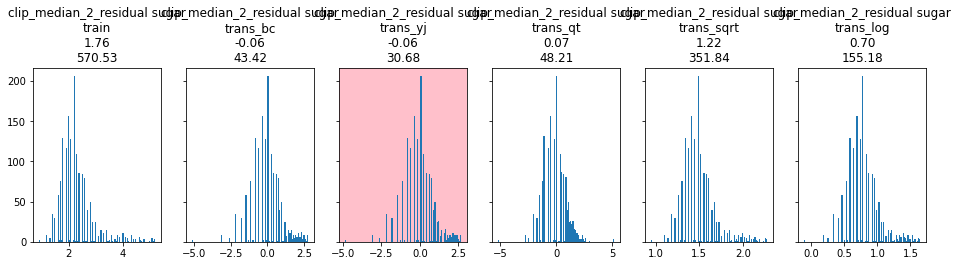

clip_median_2_chlorides 115
Best:trans_qt


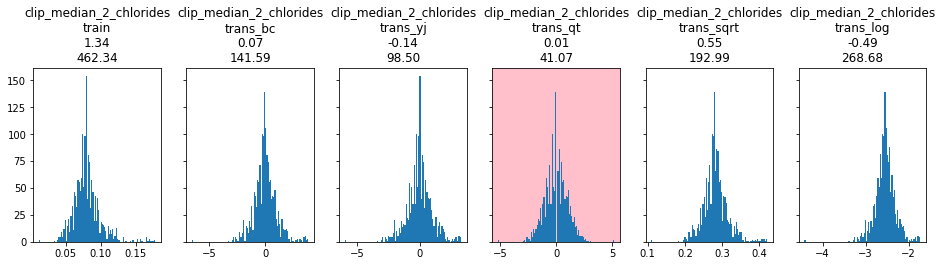

clip_median_2_free sulfur dioxide 37
Best:trans_yj


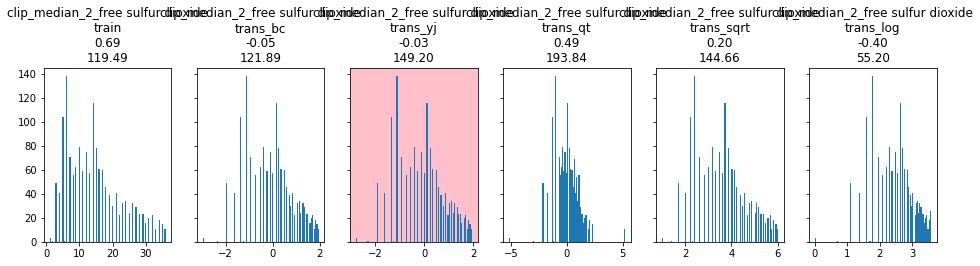

clip_median_2_total sulfur dioxide 106
Best:trans_qt


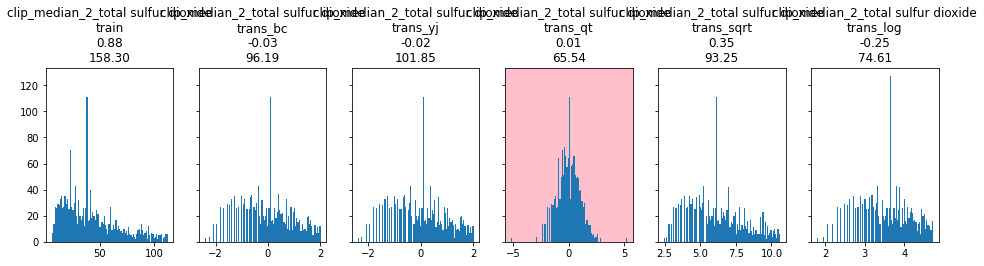

clip_median_2_density 392
Best:trans_bc


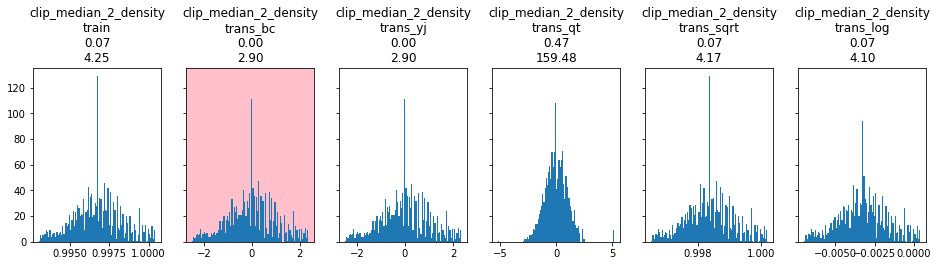

clip_median_2_pH 61
Best:trans_yj


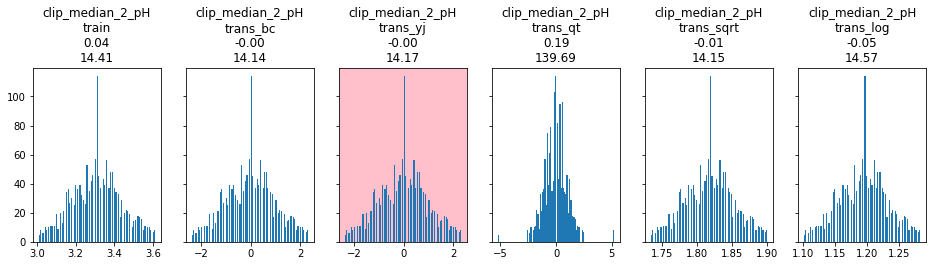

clip_median_2_sulphates 62
Best:trans_bc


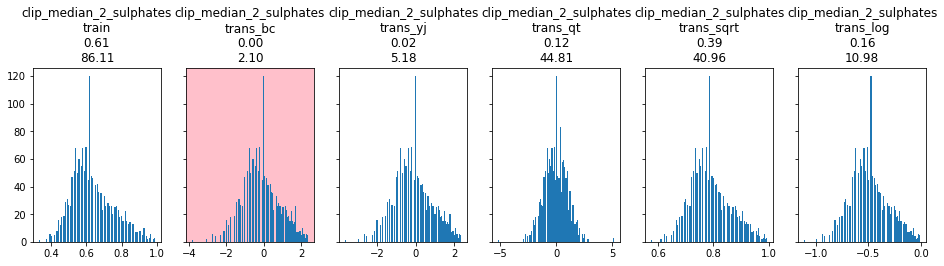

clip_median_2_alcohol 51
Best:trans_bc


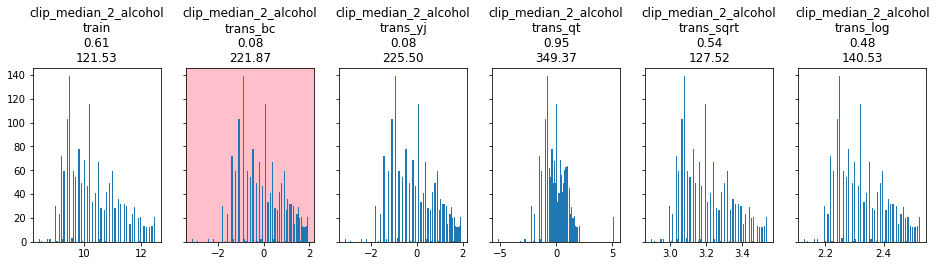

clip_median_1.5_fixed acidity 52
Best:trans_bc


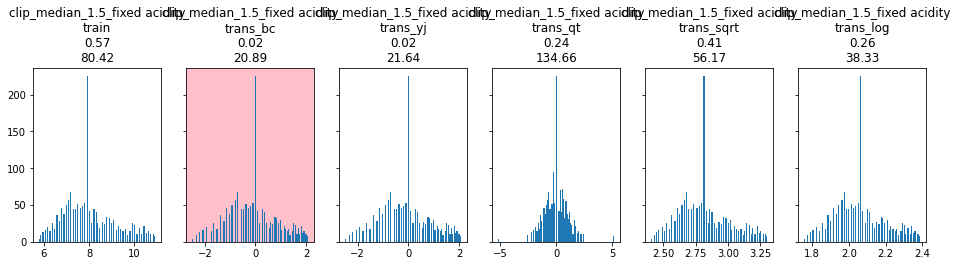

clip_median_1.5_volatile acidity 86
Best:trans_yj


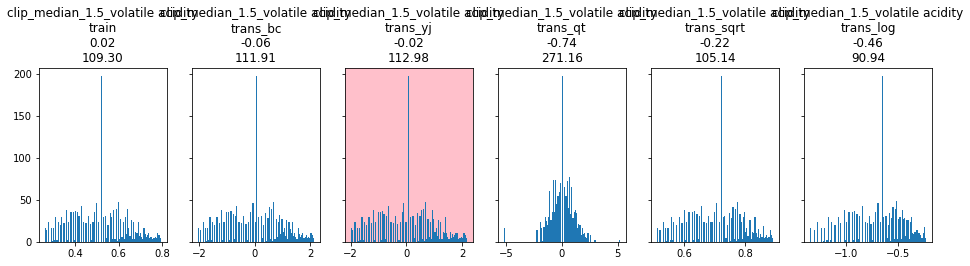

clip_median_1.5_citric acid 57
Best:trans_yj


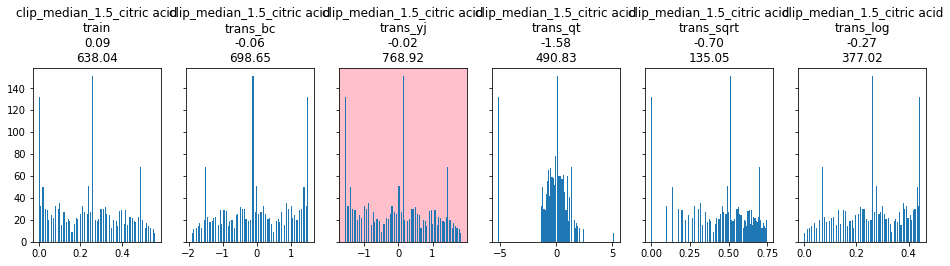

clip_median_1.5_residual sugar 51
Best:trans_qt


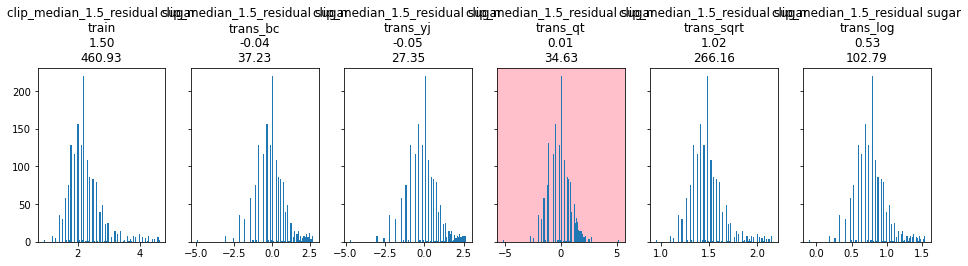

clip_median_1.5_chlorides 102
Best:trans_bc


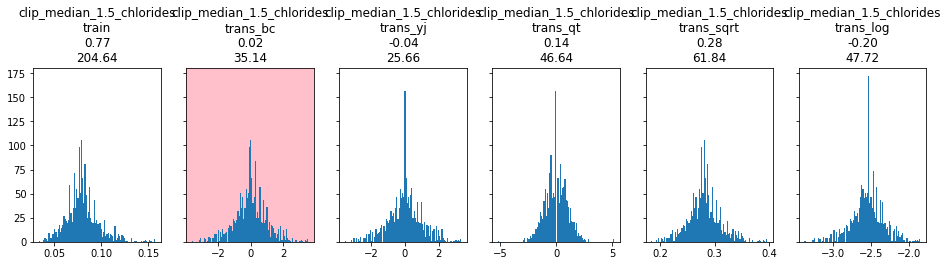

clip_median_1.5_free sulfur dioxide 32
Best:trans_yj


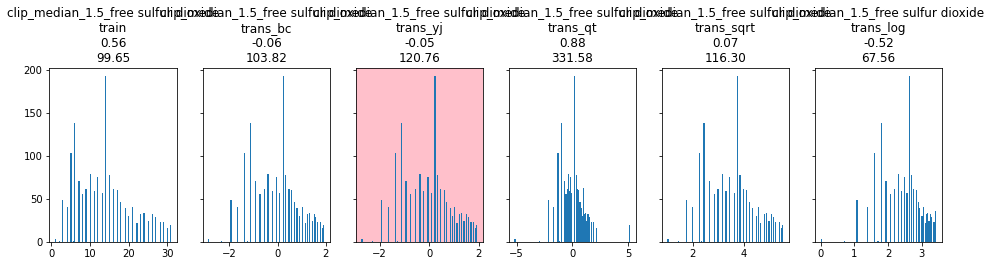

clip_median_1.5_total sulfur dioxide 91
Best:trans_yj


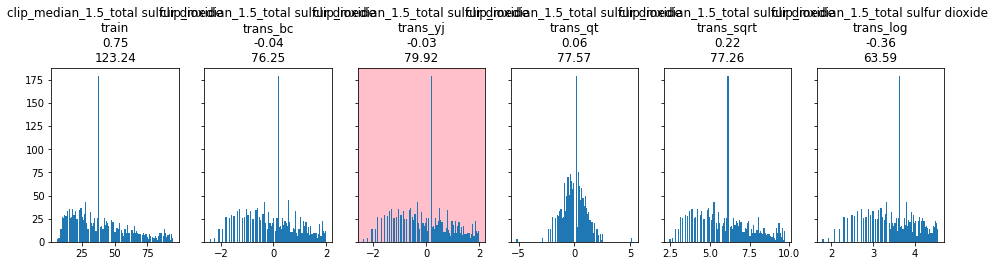

clip_median_1.5_density 335
Best:trans_bc


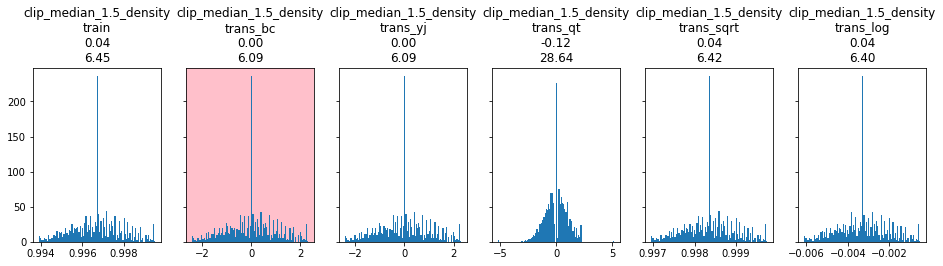

clip_median_1.5_pH 47
Best:trans_yj


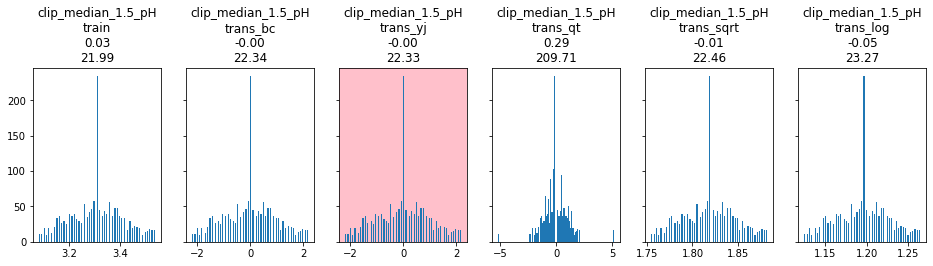

clip_median_1.5_sulphates 50
Best:trans_bc


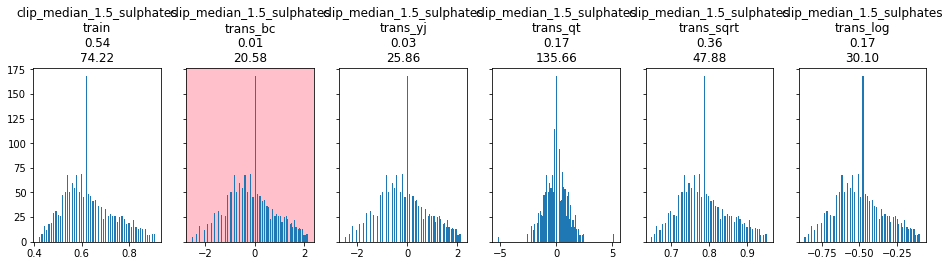

clip_median_1.5_alcohol 42
Best:trans_bc


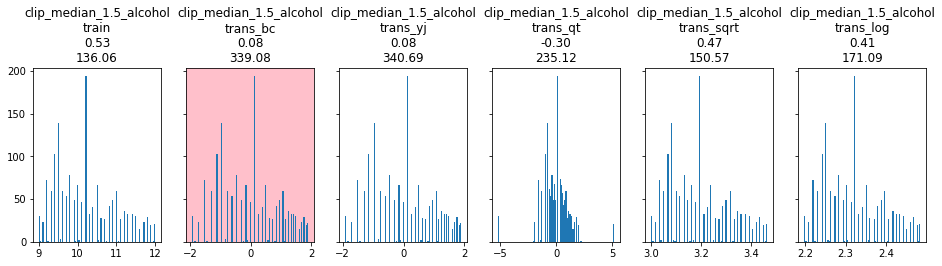

clip_median_1_fixed acidity 35
Best:trans_bc


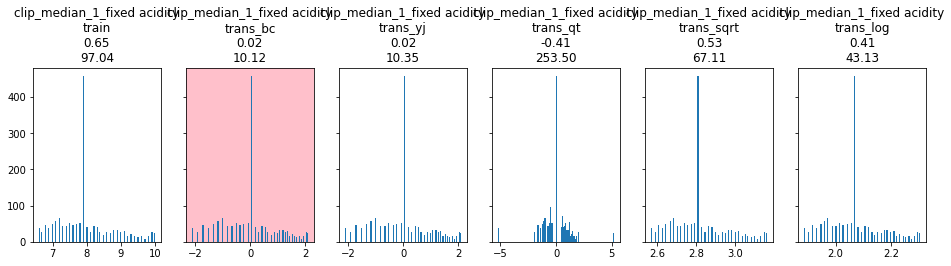

clip_median_1_volatile acidity 56
Best:train


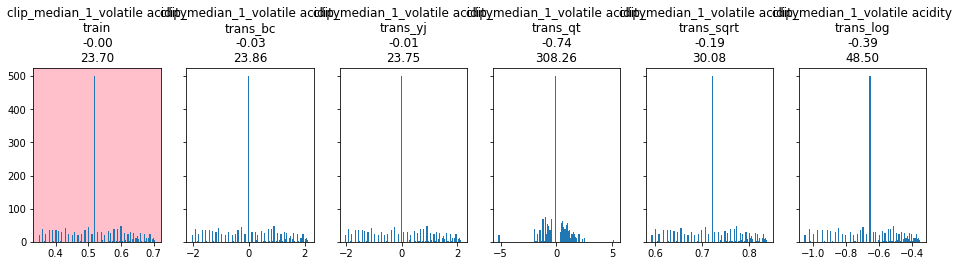

clip_median_1_citric acid 39
Best:trans_yj


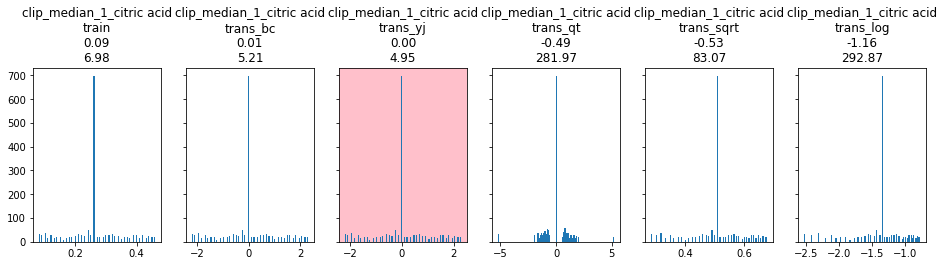

clip_median_1_residual sugar 41
Best:trans_bc


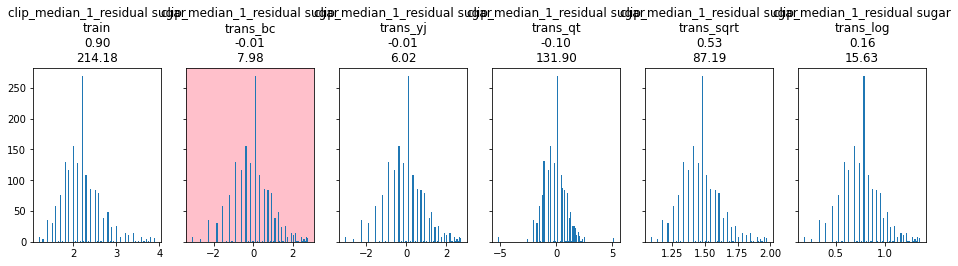

clip_median_1_chlorides 89
Best:trans_bc


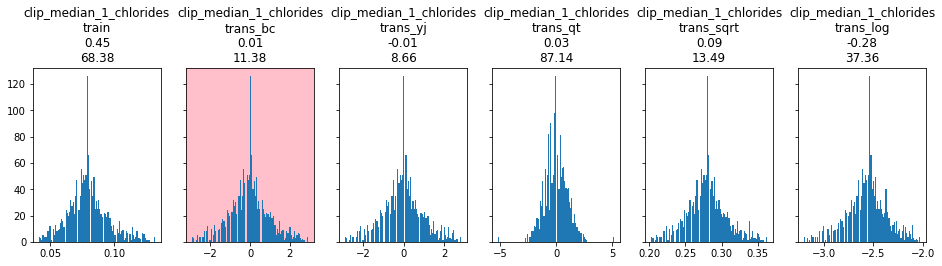

clip_median_1_free sulfur dioxide 22
Best:trans_yj


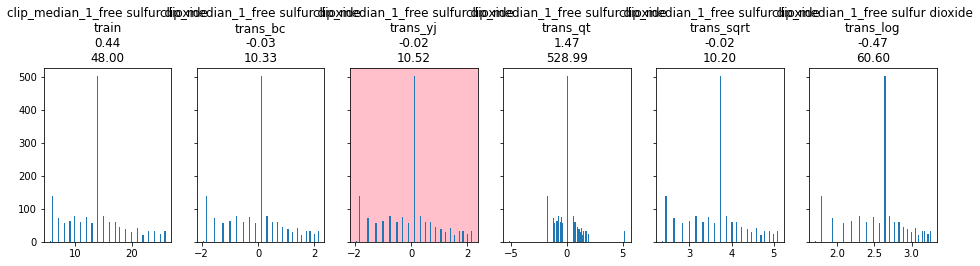

clip_median_1_total sulfur dioxide 67
Best:trans_yj


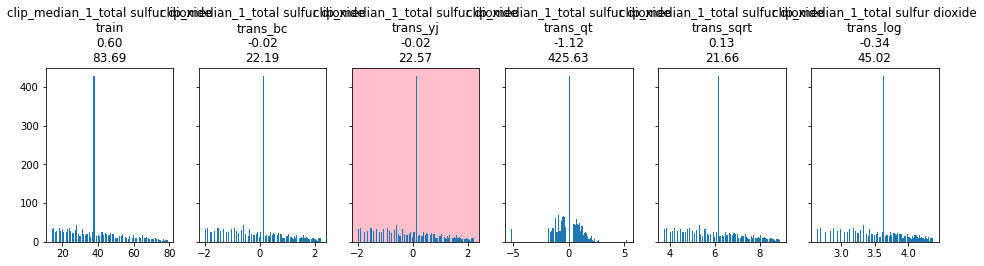

clip_median_1_density 265
Best:trans_yj


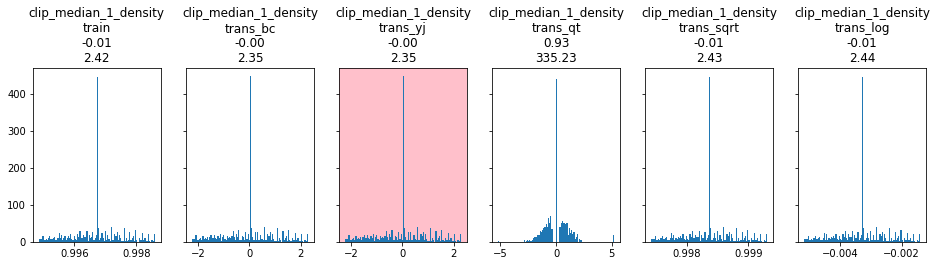

clip_median_1_pH 31
Best:trans_yj


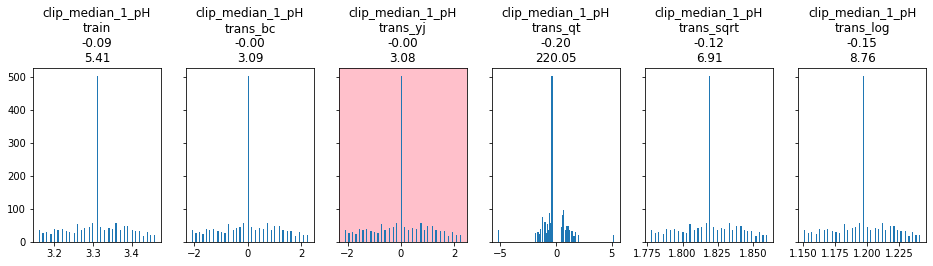

clip_median_1_sulphates 34
Best:trans_bc


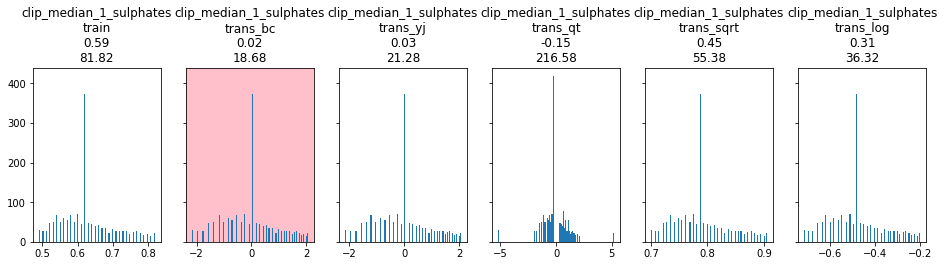

clip_median_1_alcohol 28
Best:trans_bc


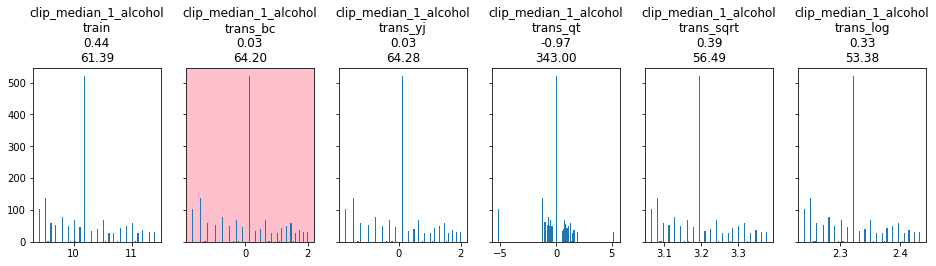

In [ ]:
#collapse_show
#get column locations of all features; need to exclude the Bools
int_features_indices = np.where(clipped_median_dfs.dtypes == 'float64')[0]

clipped_transform_dfs = []
for feature_index in int_features_indices:
  transform_df = plot_transforms(clipped_median_dfs, feature_index, log=False)
  clipped_transform_dfs.append(transform_df)

clipped_transform_dfs = pd.concat(clipped_transform_dfs, axis=1)

#save to csv for later processing
csv_path = (base_dir+'/clipped_transform_dfs.csv')
clipped_transform_dfs.to_csv(csv_path, index=False)

We see that the clipped transforms feature set has increased from 11 features to 55.

In [ ]:
#shape = 11 features x 5 clips = 55
clipped_transform_dfs.shape

(1599, 55)

Now for the real test, lets see how a neural network is effected by these modifications.


1.   We will try a baseline with the default feaature set.
2.   Replace the 'alcohol' feature with the QuantileTransformer version of the same feature.
3.   Replace the 'alcohol' feature with Box-Cox, clipped to 2 standard deviations and set to the median.
4.   Use all 3 'alcohol' columns

Note-for now, all other features will be kept as default.



#stratified cross validation

Summary of the models can be found in the table below.  Did not see the impact I expected with the updated models.  However, I only transformed 1 of the 11 features.  In the next post, we will look at the results of transforming all the features. 

| Model       | Average accuracy over 5 folds (%)
| ----------- | ----------------                                      |
| XGB Baseline                                  | 92.5             |
| XGB : quantile transform                      | 92.5             |
| XGB : clipped to median                       | 91.6             |
| XGB : clipped to median/Box-Cox transform     | 91.3             |
| XGB : all of the above in one model.          | 90.3             |
| Neural Baseline          | 89.9             |
| Neural network : all of the above in one model.          | 90.3 |
| Neural network : reduced to 11 features          | 89.9         |
| Neural network : baseline + transform of baseline          | 91.2 |
| Neural network : reduced after Shaply feature importance  |  88.7  |



# Quick analysis with XGBoost

Interestingly, the XGB model had a score of 92.5%.  The best score I've seen on Kaggle was around ~91%.

In [ ]:
if 1:
  bins = (2, 6.5, 8)
  group_names = ['bad', 'good']
  df['quality'] = pd.cut(df['quality'], bins = bins, labels = group_names)



In [ ]:
#collapse_show
from xgboost import XGBClassifier

y_test=df.quality
df2=df.copy()
df2.drop('quality', axis=1, inplace=True)

def xgb_score(df2, depth=2):
  X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(df2, y_test, test_size=.2, random_state=0)
  clf = XGBClassifier(max_depth=depth, learning_rate=.008)#(max_depth=200, random_state=seed, oob_score=True, min_samples_split=30)
  clf.fit(X_train_combined, y_train_combined)
  print (clf.score(X_test_combined, y_test_combined))
  return clf
_ = xgb_score(df2)

0.925


Decision trees are not impacted by shape of the input features.  So, in theory, the score of the transformed and default data should be identical.

Yes, they are the same as expected.

In [ ]:
_ = xgb_score(transform_dfs) # in theory, this should match baseline

0.925


The clipped transformed data consists of modified data, so we would expect the scores to be different.

Yes, it's different and a little worse.

In [ ]:
xgb_score(clipped_transform_dfs, depth=3)

0.915625


Again, the scores will be differnt fro the original and we confirmed they are different.

In [ ]:
# need to convert bool to numbers for xgboost
clipped_median_df2 = clipped_median_dfs.copy()
#clipped_median_df2.replace({False: 0.0, True: 1.0}, inplace=True)

_ = xgb_score(clipped_median_df2, depth=3)

0.9125


In [ ]:
d=pd.concat([df2, transform_dfs, clipped_transform_dfs, clipped_median_df2], axis=1)

#save to csv for later processing
csv_path = (base_dir+'/all_transforms_dfs.csv')
d.to_csv(csv_path, index=False)

In [ ]:
df2.shape, transform_dfs.shape, clipped_transform_dfs.shape, clipped_median_df2.shape

((1599, 11), (1599, 11), (1599, 55), (1599, 165))

In [ ]:
clf=xgb_score(d, depth=3)

0.903125


In [ ]:
#collapse_show
def feat_importance(m, df):
  # get list of feature importance for given model
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                      ).sort_values('imp', ascending=False)

The most important feature with the Quantile transform of 'alcohol'. Which shows we are on the right track.

In the next Blog, I will investigate the results after transforming the entire feature set.

In [ ]:
#collapse_show
fi=feat_importance(clf, d)
fi[:30]

,cols,imp
10,alcohol,0.160523
76,clip_median_1_alcohol_trans_bc,0.076725
64,clip_median_1.5_sulphates_trans_bc,0.067314
9,sulphates,0.064089
1,volatile acidity,0.063546
41,clip_median_2.5_pH_trans_yj,0.051627
56,clip_median_1.5_volatile acidity_trans_yj,0.044594
53,clip_median_2_sulphates_trans_bc,0.042041
57,clip_median_1.5_citric acid_trans_yj,0.041968
2,citric acid,0.039868


# Analyze the data with a neural network

In [23]:
#collapse_hide
from sklearn.model_selection import StratifiedKFold
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'redwine'

csv_path = (base_dir+'/all_transforms_dfs.csv')
df=pd.read_csv(csv_path)


csv_path = (base_dir+'/winequality-red.csv')
df_quality=pd.read_csv(csv_path)

df['quality']=df_quality['quality']

# Convert dep_variable to binary classification problem
# bad vs good wine
bins = (2, 6.5, 8)
group_names = ['bad', 'good']
df['quality'] = pd.cut(df['quality'], bins = bins, labels = group_names)


def get_cat_cont_features(df, dep_variable):

  cat_names = [col for col in df.columns if 'IS_CLIP' in col]
  cont_names = [col for col in df.columns if 'IS_CLIP' not in col]
  dep_var = 'quality'

  # Remove dep variable from list
  cat_names = [y for y in cat_names if y != dep_var]

  # Remove dep variable from list
  cont_names = [y for y in cont_names if y != dep_var]


  #drop duplicate columns (quality is in the df 4 times)
  df = df.loc[:,~df.columns.duplicated()]
  return cat_names, cont_names

Split continuous and categorical data for processing.  

In [24]:
cat_names, cont_names = get_cat_cont_features(df, 'quality')

In [21]:
#hide
dep_var = 'quality'
cont_names, cat_names = cont_cat_split(df, max_card=50, dep_var=dep_var)

In [ ]:
#hide
resumetable(df)

Update FASTAIs Categorify to support stratisfied kFold

In [25]:
#collapse_hide

def _apply_cats (voc, add, c):
    if not is_categorical_dtype(c):
        return pd.Categorical(c, categories=voc[c.name][add:]).codes+add
    return c.cat.codes+add #if is_categorical_dtype(c) else c.map(voc[c.name].o2i)
def _decode_cats(voc, c): return c.map(dict(enumerate(voc[c.name].items)))


class Categorify(TabularProc):
    "Transform the categorical variables to something similar to `pd.Categorical`"
    order = 1
    def __init__(self, classes=None):
        if classes is None: classes = defaultdict(L)
        store_attr()
        super().__init__()
    def setups(self, to):
        for n in to.cat_names:
            if n not in self.classes or is_categorical_dtype(to[n]):
                self.classes[n] = CategoryMap(to.iloc[:,n].items, add_na=n)

    def encodes(self, to): to.transform(to.cat_names, partial(_apply_cats, self.classes, 1))
    def decodes(self, to): to.transform(to.cat_names, partial(_decode_cats, self.classes))
    def __getitem__(self,k): return self.classes[k]


@patch
def __init__(x:Normalize, mean=None, std=None, axes=(0,2,3), means=None, stds=None): store_attr()

# Cell
@Normalize
def setups(self, to:Tabular):
    if self.means is None:
        self.means = dict(getattr(to, 'train', to).conts.mean())
        self.stds  = dict(getattr(to, 'train', to).conts.std(ddof=0)+1e-7)
    else:
        for name in getattr(to, 'train', to).conts.columns:
            if name not in self.means.keys():
                self.means[name] = getattr(to, 'train', to)[name].mean()
            if name not in self.stds.keys():
                self.stds[name] = getattr(to, 'train', to)[name].std(ddof=0)+1e-7

    return self(to)

Split data for train and validation

In [26]:
#collapse_hide
print(f'10% of our data is {int(len(df) * .1)} rows')
start_val = len(df) - 159
train = df.iloc[:start_val]
test = df.iloc[start_val:]

10% of our data is 159 rows


Initialize the processes (these is needed up front in anticipation of using statisfied kfolds)

In [27]:
#collapse_hide
procs = [Categorify, FillMissing, Normalize]
to_base = TabularPandas(train, procs, cat_names, cont_names, y_names='quality')

classes = to_base.classes
means, stds = to_base.normalize.means, to_base.normalize.stds
fill_vals, na_dict = to_base.fill_missing.fill_vals, to_base.fill_missing.na_dict

In [15]:
#procs = [Categorify(classes), Normalize(means, stds), FillMissing(fill_strategy=FillStrategy.median, fill_vals=fill_vals)]

In [29]:
#collapse_output
val_pct, tst_preds = L(), L()
skf = StratifiedKFold(n_splits=5, shuffle=False)
for train_idx, valid_idx in skf.split(train.index, train['quality']): # right here
    splits = (L(list(train_idx)), L(list(valid_idx)))
    procs = [Categorify(classes), Normalize]
    to = TabularPandas(train, procs, cat_names, cont_names, y_names='quality',
                       splits=splits)
    dls = to.dataloaders(bs=64)
    learn = tabular_learner(dls, layers=[200,100], metrics=accuracy)
    lr_in, lr_steep = learn.lr_find(show_plot=False)
    print (lr_in, lr_steep)
    learn.fit_one_cycle(30, (lr_steep), cbs=[EarlyStoppingCallback( 
        monitor='accuracy', min_delta=0.001, patience=3),
         SaveModelCallback(monitor='accuracy'), ReduceLROnPlateau(monitor='accuracy')])
          # GradientAccumulation(64), ReduceLROnPlateau(monitor='accuracy'),
          # ])
    test_dl = learn.dls.test_dl(test)
    with learn.no_bar():
        val_pct.append(learn.validate()[-1])
        tst_preds.append(learn.get_preds(dl=test_dl))

0.02089296132326126 0.004365158267319202


epoch,train_loss,valid_loss,accuracy,time
0,0.635723,0.570992,0.871528,00:01
1,0.477337,0.341124,0.868056,00:01
2,0.376671,0.327387,0.868056,00:01
3,0.314081,0.326399,0.871528,00:01


Better model found at epoch 0 with accuracy value: 0.8715277910232544.
Epoch 1: reducing lr to 8.320166602993341e-05
Epoch 2: reducing lr to 0.00015762129918810885
No improvement since epoch 0: early stopping


0.03019951581954956 0.002511886414140463


epoch,train_loss,valid_loss,accuracy,time
0,0.559900,0.602222,0.809028,00:01
1,0.444716,0.389565,0.854167,00:01
2,0.354062,0.314223,0.850694,00:01
3,0.297444,0.334917,0.843750,00:01
4,0.252765,0.440657,0.784722,00:01


Better model found at epoch 0 with accuracy value: 0.8090277910232544.
Better model found at epoch 1 with accuracy value: 0.8541666865348816.
Epoch 2: reducing lr to 9.07015910451587e-05
Epoch 3: reducing lr to 0.0001404275566817023
No improvement since epoch 1: early stopping


0.010000000149011612 0.0063095735386013985


epoch,train_loss,valid_loss,accuracy,time
0,0.440998,0.393067,0.895833,00:01
1,0.346711,0.261432,0.871528,00:01
2,0.297839,0.245532,0.892361,00:01
3,0.268423,0.333334,0.885417,00:01


Better model found at epoch 0 with accuracy value: 0.8958333134651184.
Epoch 1: reducing lr to 0.0001202630003773997
Epoch 2: reducing lr to 0.00022783210082507216
No improvement since epoch 0: early stopping


0.004786301031708717 0.004365158267319202


epoch,train_loss,valid_loss,accuracy,time
0,0.460014,0.553395,0.784722,00:01
1,0.355912,0.376235,0.836806,00:01
2,0.290525,0.372059,0.812500,00:01
3,0.251851,0.320137,0.864583,00:01
4,0.222716,0.455813,0.802083,00:01
5,0.205746,0.637037,0.857639,00:01
6,0.193840,0.571623,0.826389,00:01


Better model found at epoch 0 with accuracy value: 0.7847222089767456.
Better model found at epoch 1 with accuracy value: 0.8368055820465088.
Epoch 2: reducing lr to 0.00015762129918810885
Better model found at epoch 3 with accuracy value: 0.8645833134651184.
Epoch 4: reducing lr to 0.0003275013659433987
Epoch 5: reducing lr to 0.000393587976584492
No improvement since epoch 3: early stopping


0.006918309628963471 1.0964782238006592


epoch,train_loss,valid_loss,accuracy,time
0,0.690603,0.405934,0.819444,00:01
1,1.905890,0.399246,0.850694,00:01
2,1.246344,2.421594,0.857639,00:01
3,1.544999,0.463582,0.861111,00:01
4,1.160498,2.793260,0.854167,00:01
5,0.918962,18.281952,0.854167,00:01
6,3.404279,73566.031250,0.534722,00:01


Better model found at epoch 0 with accuracy value: 0.8194444179534912.
Better model found at epoch 1 with accuracy value: 0.8506944179534912.
Better model found at epoch 2 with accuracy value: 0.8576388955116272.
Better model found at epoch 3 with accuracy value: 0.8611111044883728.
Epoch 4: reducing lr to 0.08226462685451319
Epoch 5: reducing lr to 0.09886483354008971
No improvement since epoch 3: early stopping


In [30]:
#show
for i, (pred, truth) in enumerate(tst_preds):
    print(f'Fold {i+1}: {accuracy(pred, truth)}')

sum_preds = []
for i, (pred, truth) in enumerate(tst_preds):
    sum_preds.append(pred.numpy())
avg_preds = np.sum(sum_preds, axis=0) / 5
print(f'Average Accuracy: {accuracy(tensor(avg_preds), tst_preds[0][1])}')

Fold 1: 0.805031418800354
Fold 2: 0.8867924809455872
Fold 3: 0.8805031180381775
Fold 4: 0.8867924809455872
Fold 5: 0.893081784248352
Average Accuracy: 0.893081784248352


Lets etract the embeddings, and run random forest to find the most important features.



In [34]:
def embed_features(learner, xs):
  # https://forums.fast.ai/t/using-embedding-from-the-neural-network-in-random-forests/80063/9
  # citation: danielwbn
    xs = xs.copy()
    for i, feature in enumerate(learner.dls.cat_names):
        emb = learner.model.embeds[i]
        new_feat = pd.DataFrame(emb(tensor(xs[feature], dtype=torch.int64)), index=xs.index, columns=[f'{feature}_{j}' for j in range(emb.embedding_dim)])
        xs.drop(columns=feature, inplace=True)
        xs = xs.join(new_feat)
    return xs


def feat_importance(m, df):
  # get list of feature importance for given model
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                      ).sort_values('imp', ascending=False)
                      

# after fitting, get embeddings to be used by ML
embeded_xs = embed_features(learn, learn.dls.train.xs)
xs_valid = embed_features(learn, learn.dls.valid.xs)

embeded_ys = learn.dls.train.ys
ys_valid = learn.dls.valid.ys

In [35]:
y_test=df.quality
df2=df.copy()
df2.drop('quality', axis=1, inplace=True)

In [36]:
from xgboost import XGBClassifier

X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(df2, y_test, test_size=.2, random_state=0)
clf = XGBClassifier(max_depth=2, learning_rate=.008, random_state=0, oob_score=True, min_samples_split=30)
clf.fit(X_train_combined, y_train_combined)
print (clf.score(X_test_combined, y_test_combined))

0.9125


Interestingly, none of the pure transformations helped with the model.

Hmm, this needs investigating.  But first let's keep the most important features and re-run the test.

Out of 243 features, only 11 are having an impact on our model. (note - this is with a max_depth set to 2 on the XGBboost model)

In [37]:
#show
fi=feat_importance(clf, X_train_combined)
fi[:15]

,cols,imp
10,alcohol,0.233705
9,sulphates,0.139029
2,citric acid,0.114574
1,volatile acidity,0.113063
32,clip_median_3_alcohol_trans_bc,0.098769
64,clip_median_1.5_sulphates_trans_bc,0.092401
31,clip_median_3_sulphates_trans_bc,0.090288
56,clip_median_1.5_volatile acidity_trans_yj,0.061371
44,clip_median_2_fixed acidity_trans_bc,0.023817
0,fixed acidity,0.017039


Reduce the features and check the score.  Yes, it does not change.

In [39]:
#show
to_keep = fi[fi.imp>0.001].cols
len(to_keep)

xs_imp = X_train_combined[to_keep]
valid_xs_imp = X_test_combined[to_keep]

clf.fit(xs_imp, y_train_combined)
print (clf.score(valid_xs_imp, y_test_combined))

0.9125


The accuracy reduced to 89.9% when re-running the reduced feature set through the neural network.  I clearly reduced it too much.


The remaining curioslity is why the transforms are not having an impact.

I'm going to create a dataset that only has the baseline and the transforms of the baseline.

In [140]:
 #show
 cont_names = [col for col in df.columns if ('clip' not in col) & ('CLIP' not in col)&('quality' not in col)]
 cat_names = []

In [1]:
#hide
#Run once per session
!pip install fastai wwf fastinference[interp] -q --upgrade

In [2]:
#hide_input
from wwf.utils import state_versions
state_versions(['fastai', 'fastcore', 'wwf', 'fastinference'])


---
This article is also a Jupyter Notebook available to be run from the top down. There
will be code snippets that you can then run in any environment.

Below are the versions of `fastai`, `fastcore`, `wwf`, and `fastinference` currently running at the time of writing this:
* `fastai`: 2.2.7 
* `fastcore`: 1.3.19 
* `wwf`: 0.0.13 
* `fastinference`: 0.0.35 
---

In [5]:
from fastinference.tabular import *
from fastai.tabular.all import *

Lest evaluate the model with Shap

Nice examples can be found here.
https://slundberg.github.io/shap/notebooks/plots/dependence_plot.html



In [18]:
exp = ShapInterpretation(learn, df.iloc[:100])

Classification model detected, displaying score for the class bad.
(use `class_id` to specify another class)
Displaying row 10 of 100 (use `row_idx` to specify another row)


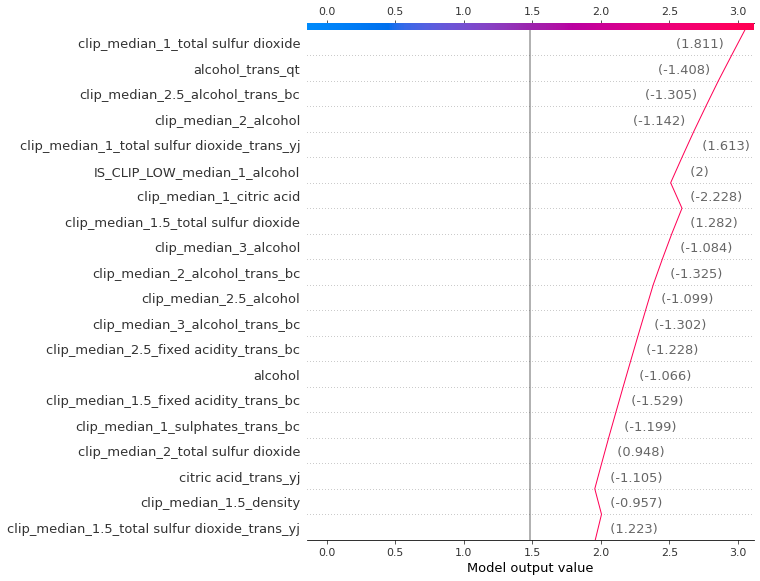

In [19]:
exp.decision_plot(class_id=0, row_idx=10)

Classification model detected, displaying score for the class good.
(use `class_id` to specify another class)
Displaying row 10 of 100 (use `row_idx` to specify another row)


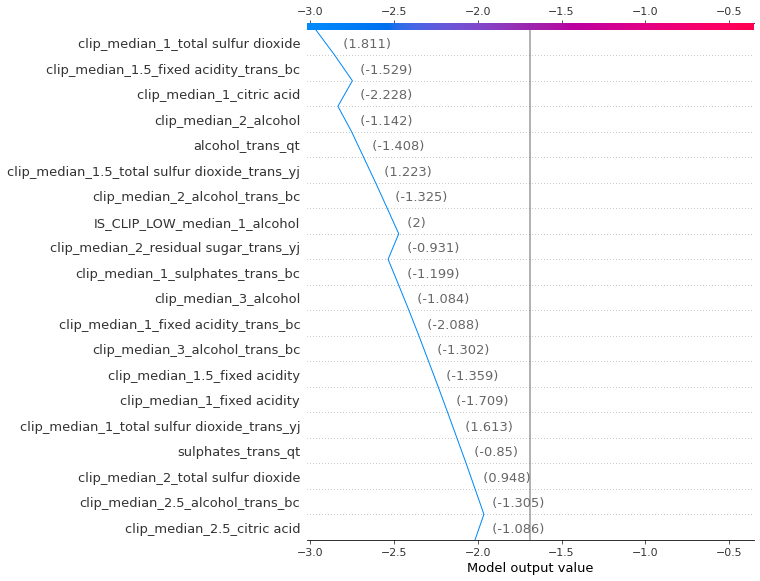

In [20]:
exp.decision_plot(class_id=1, row_idx=10)

Classification model detected, displaying score for the class good.
(use `class_id` to specify another class)


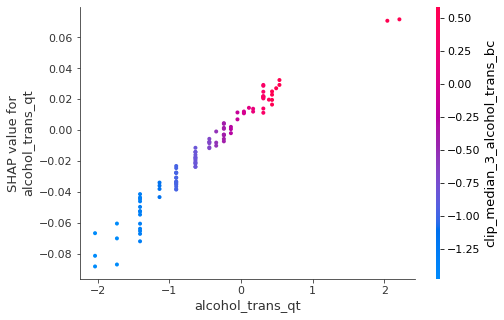

In [22]:
exp.dependence_plot('alcohol_trans_qt', class_id=1)

Classification model detected, displaying score for the class good.
(use `class_id` to specify another class)


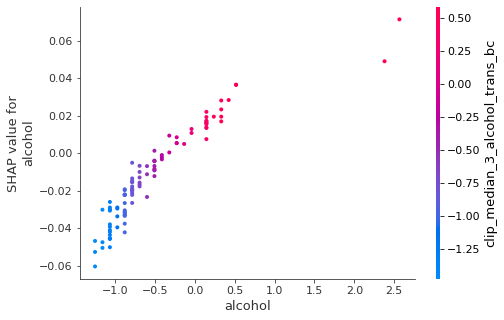

In [25]:
exp.dependence_plot('alcohol', class_id=1, interaction_index="clip_median_3_alcohol_trans_bc")

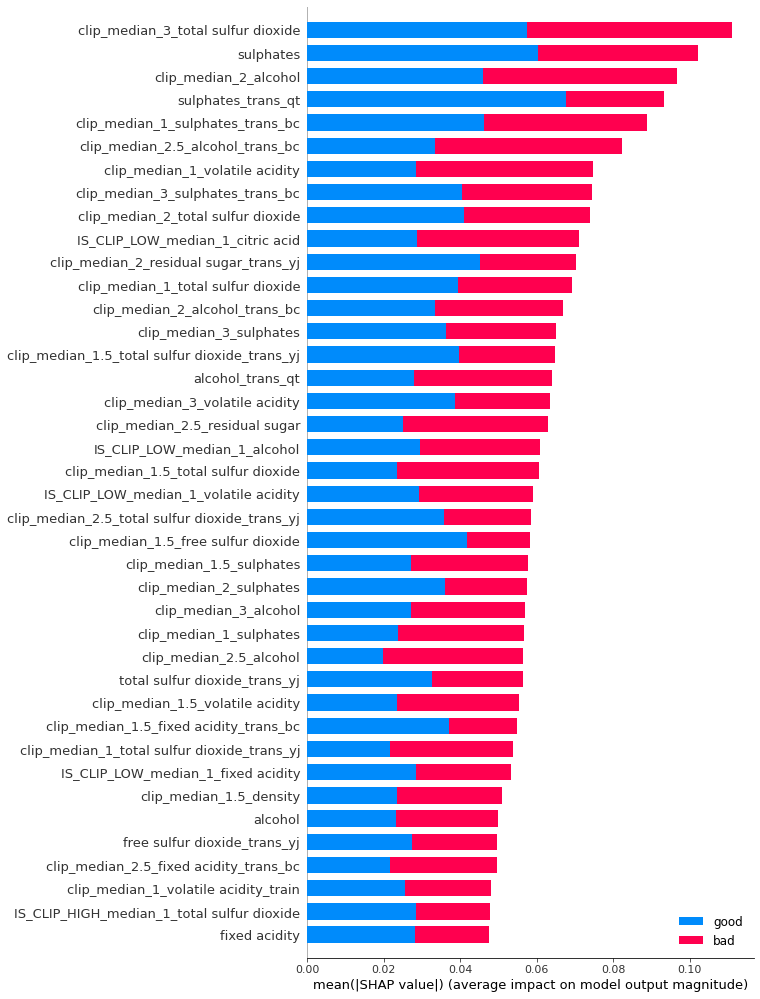

In [31]:
exp.summary_plot(max_display=40)

In [39]:
X_importance=exp.test_data
shap_values=exp.shap_vals

In [42]:
shap_sum.shape

(100, 242)

In [43]:
tmp=np.abs(shap_values)

In [44]:
tmp.shape

(2, 100, 242)

In [48]:
shap_sum = np.abs(shap_values[0]).mean(axis=0)
importance_df = pd.DataFrame([X_importance.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df[:20]

,column_name,shap_importance
193,clip_median_3_total sulfur dioxide,0.0536438
219,clip_median_2_alcohol,0.0507021
153,clip_median_2.5_alcohol_trans_bc,0.0489006
232,clip_median_1_volatile acidity,0.0463179
185,clip_median_1_sulphates_trans_bc,0.0426078
92,IS_CLIP_LOW_median_1_citric acid,0.0421698
119,sulphates,0.0418012
201,clip_median_2.5_residual sugar,0.0378305
226,clip_median_1.5_total sulfur dioxide,0.0370194
208,clip_median_2.5_alcohol,0.0366867


In [56]:
nn_features_to_keep = importance_df[importance_df.shap_importance>0.01].column_name

In [57]:
nn_features_to_keep

193              clip_median_3_total sulfur dioxide
219                           clip_median_2_alcohol
153                clip_median_2.5_alcohol_trans_bc
232                  clip_median_1_volatile acidity
185                clip_median_1_sulphates_trans_bc
                           ...                     
98         IS_CLIP_LOW_median_1_free sulfur dioxide
161                  clip_median_2_density_trans_bc
105                        IS_CLIP_HIGH_median_1_pH
79     IS_CLIP_HIGH_median_1.5_total sulfur dioxide
209                     clip_median_2_fixed acidity
Name: column_name, Length: 114, dtype: object

In [66]:
df=df[nn_features_to_keep]
df['quality']=y_test
train = df.iloc[:start_val]
test = df.iloc[start_val:]

good examples of using shap

https://www.kaggle.com/wrosinski/shap-feature-importance-with-feature-engineering